In [511]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
df = pd.read_csv('./data/csv/image-data.csv', usecols=['time', 'mean_gray', 'count_pixels_lighter'])

# Convert the 'time' column to datetime format
df['time'] = pd.to_datetime(df['time'])

df

,time,mean_gray,count_pixels_lighter
0,2024-06-28 22:59:15.651947,25.383881,1129
1,2024-06-28 23:19:42.605933,25.088899,1434
2,2024-06-28 23:20:15.055077,25.257823,804
3,2024-06-28 23:21:15.022617,25.119673,166
4,2024-06-28 23:22:15.022551,25.385512,204
...,...,...,...
162299,2024-11-01 13:16:35.105059,29.154994,66741
162300,2024-11-01 13:17:35.303046,29.413673,68194
162301,2024-11-01 13:18:35.105863,29.393611,71454
162302,2024-11-01 13:19:35.303264,29.400202,73040


In [512]:
df.describe()

,time,mean_gray,count_pixels_lighter
count,162303,162304.000000,162304.000000
mean,2024-08-27 03:19:45.906673664,31.232943,43006.834089
min,2024-06-28 22:59:15.651947,10.137477,15.000000
25%,2024-07-27 10:49:11.845084160,20.126410,20174.750000
50%,2024-08-27 07:05:51.077687040,29.981545,41134.500000
75%,2024-09-24 22:54:21.142177024,40.670245,57718.250000
max,2024-11-01 13:20:35.303096,113.352662,642547.000000
std,NaN,14.144934,30290.944788


In [513]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162304 entries, 0 to 162303
Data columns (total 3 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   time                  162303 non-null  datetime64[ns]
 1   mean_gray             162304 non-null  float64       
 2   count_pixels_lighter  162304 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 3.7 MB


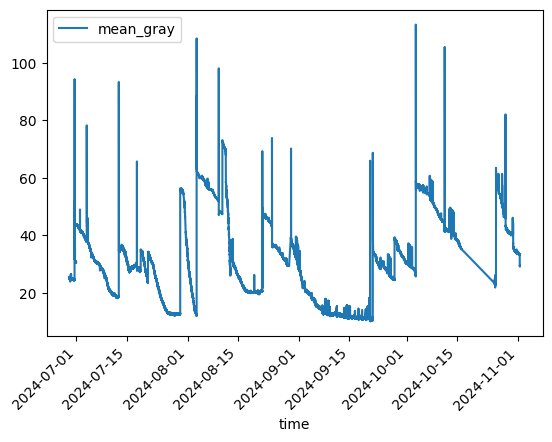

In [514]:
df.plot(x='time', y=['mean_gray'], kind='line')
plt.xticks(rotation=45)
plt.show()

## Take out outlier days

Take out the days which have an extreme change in mean_gray level, caused by feeding moment, light entering bin or some adjustment to LED brightness

In [515]:
# Calculate the difference between consecutive rows
df['mean_gray_diff'] = df['mean_gray'].diff().abs()

# Normalize the 'mean_gray_diff' column
df.loc[:, 'mean_gray_diff_normalized'] = (df['mean_gray_diff'] - df['mean_gray_diff'].min()) / (df['mean_gray_diff'].max() - df['mean_gray_diff'].min())

# Delete first row with NaN value
df = df.dropna(subset=['mean_gray_diff'])

df['mean_gray_diff_normalized']

1         0.004210
2         0.002411
3         0.001972
4         0.003794
5         0.000272
            ...   
162299    0.003712
162300    0.003692
162301    0.000286
162302    0.000094
162303    0.000003
Name: mean_gray_diff_normalized, Length: 162303, dtype: float64

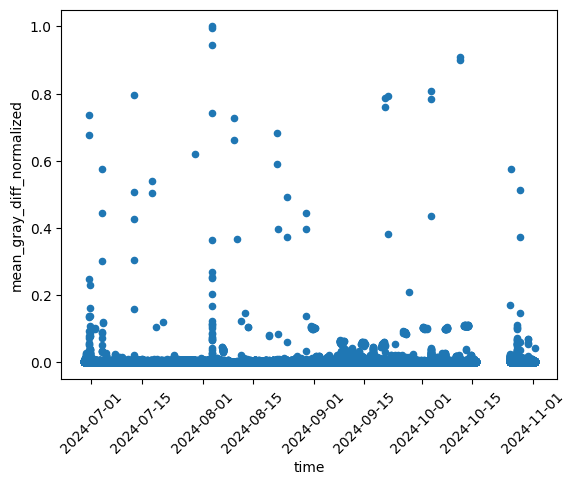

In [516]:
df.plot(kind="scatter", x="time", y="mean_gray_diff_normalized")
plt.xticks(rotation=45)
plt.show()

### Group by days

In [517]:
# Group by day
df.resample('D', on='time').agg({
    'mean_gray': 'mean',
    'mean_gray_diff': 'max',
    'mean_gray_diff_normalized': 'max',
    'count_pixels_lighter': lambda x: x.diff().abs().sum(),
})
df_by_day


,mean_gray,mean_gray_diff,mean_gray_diff_normalized,count_pixels_lighter
time,,,,
2024-06-28,25.177406,0.303804,0.004336,22663
2024-06-29,24.884902,1.890677,0.026982,826212
2024-06-30,30.382977,51.533718,0.735445,4093642
2024-07-01,43.052295,0.597771,0.008531,3651325
2024-07-02,41.182413,7.089539,0.101176,7418499
...,...,...,...,...
2024-10-28,45.008231,35.958570,0.513170,93791939
2024-10-29,41.372159,0.877776,0.012527,138661651
2024-10-30,38.872445,4.962055,0.070814,136393567


In [518]:
# Add a column for the week of the year
df_by_day['week_of_year'] = df_by_day.index.isocalendar().week

df_by_day.head()

,mean_gray,mean_gray_diff,mean_gray_diff_normalized,count_pixels_lighter,week_of_year
time,,,,,
2024-06-28,25.177406,0.303804,0.004336,22663,26
2024-06-29,24.884902,1.890677,0.026982,826212,26
2024-06-30,30.382977,51.533718,0.735445,4093642,26
2024-07-01,43.052295,0.597771,0.008531,3651325,27
2024-07-02,41.182413,7.089539,0.101176,7418499,27


### Add the slope

In [519]:
# Calculate the slope between consecutive days
df_by_day.loc[:, 'slope'] = df_by_day['mean_gray'].diff() / df_by_day.index.to_series().diff().dt.days

# Drop the first row as it will have NaN slope
df_by_day = df_by_day.dropna(subset=['slope'])

df_by_day


,mean_gray,mean_gray_diff,mean_gray_diff_normalized,count_pixels_lighter,week_of_year,slope
time,,,,,,
2024-06-29,24.884902,1.890677,0.026982,826212,26,-0.292504
2024-06-30,30.382977,51.533718,0.735445,4093642,26,5.498075
2024-07-01,43.052295,0.597771,0.008531,3651325,27,12.669318
2024-07-02,41.182413,7.089539,0.101176,7418499,27,-1.869882
2024-07-03,39.924396,40.338089,0.575671,11842906,27,-1.258017
...,...,...,...,...,...,...
2024-10-28,45.008231,35.958570,0.513170,93791939,44,-6.675343
2024-10-29,41.372159,0.877776,0.012527,138661651,44,-3.636072
2024-10-30,38.872445,4.962055,0.070814,136393567,44,-2.499714


<Axes: ylabel='Frequency'>

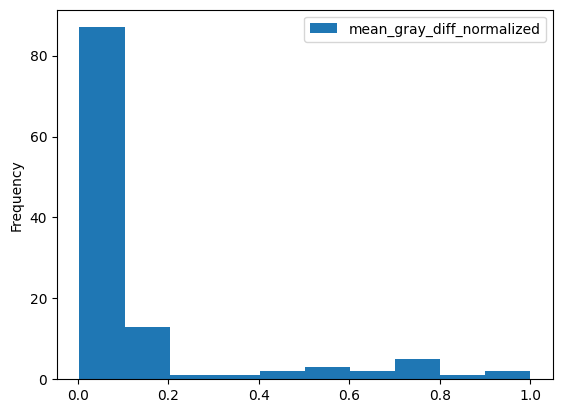

In [520]:
df_by_day.plot(kind='hist', y='mean_gray_diff_normalized')

<Axes: >

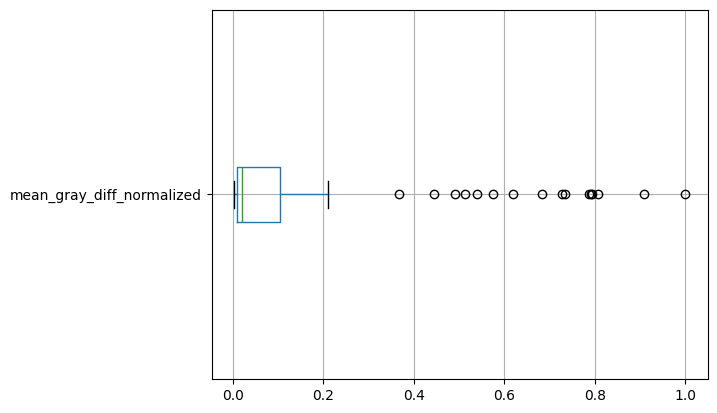

In [521]:
df_by_day.boxplot(column='mean_gray_diff_normalized', vert=False)

In [522]:
df_cleaned = df_by_day[df_by_day['mean_gray_diff_normalized'] < 0.1]
df_cleaned

,mean_gray,mean_gray_diff,mean_gray_diff_normalized,count_pixels_lighter,week_of_year,slope
time,,,,,,
2024-06-29,24.884902,1.890677,0.026982,826212,26,-0.292504
2024-07-01,43.052295,0.597771,0.008531,3651325,27,12.669318
2024-07-05,33.017090,1.859740,0.026541,1320497,27,-3.967780
2024-07-06,30.769003,0.446447,0.006371,1614259,27,-2.248087
2024-07-07,29.524395,1.641413,0.023425,1533537,27,-1.244608
...,...,...,...,...,...,...
2024-10-26,56.902222,1.628876,0.023246,20162603,43,24.165071
2024-10-29,41.372159,0.877776,0.012527,138661651,44,-3.636072
2024-10-30,38.872445,4.962055,0.070814,136393567,44,-2.499714


## Check maxima and minimas

<Axes: xlabel='time'>

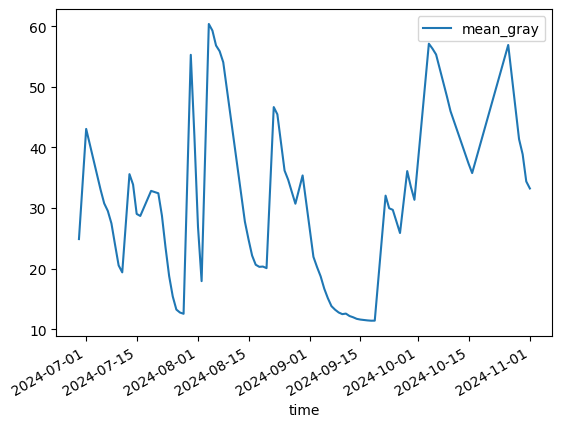

In [523]:
# Plot the aggregated data
df_cleaned[['mean_gray']].plot(kind='line')

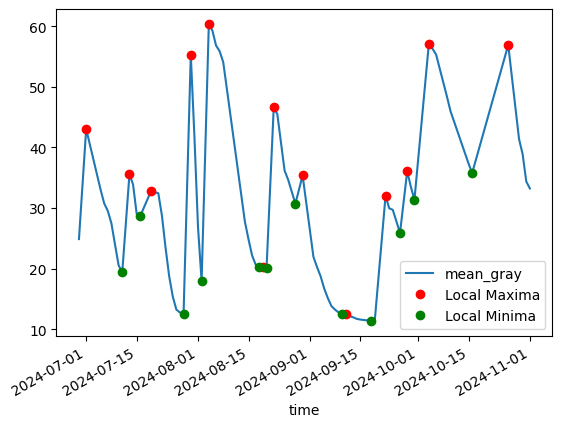

In [524]:
# Plot the maxima and minima

# Plot the aggregated data
fig, ax = plt.subplots()
df_cleaned[['mean_gray']].plot(kind='line', ax=ax)

# Find all local maxima and minima
local_maxima = df_cleaned[(df_cleaned['mean_gray'].shift(1) < df_cleaned['mean_gray']) & 
                          (df_cleaned['mean_gray'].shift(-1) < df_cleaned['mean_gray'])]

local_minima = df_cleaned[(df_cleaned['mean_gray'].shift(1) > df_cleaned['mean_gray']) & 
                          (df_cleaned['mean_gray'].shift(-1) > df_cleaned['mean_gray'])]

# Plot all local maxima and minima
ax.plot(local_maxima.index, local_maxima['mean_gray'], 'ro', label='Local Maxima')
ax.plot(local_minima.index, local_minima['mean_gray'], 'go', label='Local Minima')

ax.legend()
plt.show()


In [525]:
# Combine maxima and minima
combined = pd.concat([local_maxima, local_minima]).sort_index()

# Add a column to indicate if the point is a local maxima or minima
combined['extrema'] = ['maxima' if idx in local_maxima.index else 'minima' for idx in combined.index]

# Filter out minima that do not have a maxima before it
filtered_minima = combined[(combined['extrema'] == 'minima') & (combined.index > combined[combined['extrema'] == 'maxima'].index.min())]

# Filter out maxima that do not have a minima after it
filtered_maxima = combined[(combined['extrema'] == 'maxima') & (combined.index < combined[combined['extrema'] == 'minima'].index.max())]

# Combine the filtered maxima and minima
filtered_combined = pd.concat([filtered_maxima, filtered_minima]).sort_index()

# Define a minimum time difference threshold
time_threshold = pd.Timedelta(days=2)

# Remove maxima and minima that are close together time-wise
filtered_combined = filtered_combined[
    (filtered_combined.index.to_series().diff().abs() > time_threshold) | 
    (filtered_combined.index.to_series().diff(-1).abs() > time_threshold)
]

# Display the combined DataFrame
filtered_combined[['mean_gray', 'extrema']].head()

,mean_gray,extrema
time,,
2024-07-01,43.052295,maxima
2024-07-11,19.394533,minima
2024-07-13,35.596787,maxima
2024-07-16,28.697990,minima
2024-07-19,32.834471,maxima


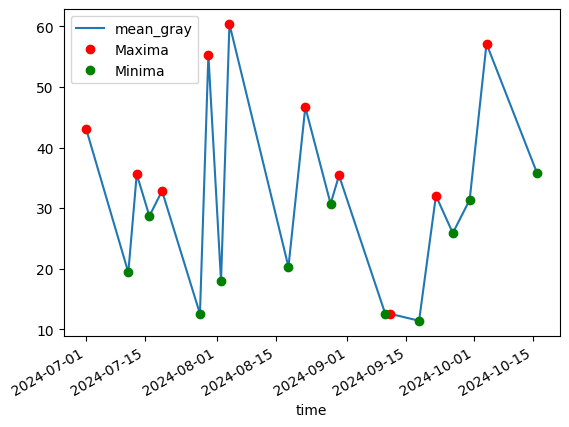

In [526]:
# Plot the maxima and minima lines

# Plot the filtered_combined DataFrame
ax = filtered_combined.plot(y='mean_gray', kind='line')

# Plot dots for maxima
ax.plot(filtered_combined[filtered_combined['extrema'] == 'maxima'].index, 
    filtered_combined[filtered_combined['extrema'] == 'maxima']['mean_gray'], 
    'ro', label='Maxima')

# Plot dots for minima
ax.plot(filtered_combined[filtered_combined['extrema'] == 'minima'].index, 
    filtered_combined[filtered_combined['extrema'] == 'minima']['mean_gray'], 
    'go', label='Minima')

# Add legend
ax.legend()
plt.show()

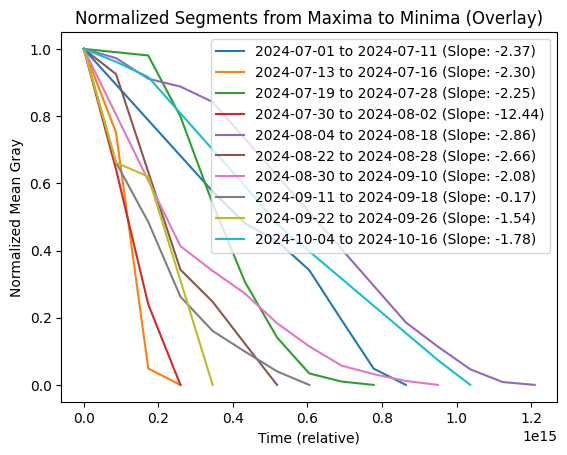

In [527]:
# Plot each line from maxima to minima over each other using index as x-axis
fig, ax = plt.subplots()

# Iterate through the filtered_combined DataFrame
for i in range(1, len(filtered_combined)):
    start = filtered_combined.index[i-1]
    end = filtered_combined.index[i]
    
    # Extract the segment between the current maxima and minima
    segment = df_cleaned.loc[start:end, 'mean_gray']
    
    # Normalize the segment
    normalized_segment = (segment - segment.min()) / (segment.max() - segment.min())
    
    # Only plot segments that start at 1 for Y axis
    if normalized_segment.iloc[0] == 1:
        # Calculate the slope
        delta_y = segment.iloc[-1] - segment.iloc[0]
        delta_x = (end - start).days
        slope = delta_y / delta_x if delta_x != 0 else float('inf')
        
        # Plot the normalized segment using the index as x-axis
        ax.plot(normalized_segment.index - normalized_segment.index[0], normalized_segment.values, label=f'{start.date()} to {end.date()} (Slope: {slope:.2f})')

# Add labels and title
ax.set_xlabel('Time (relative)')
ax.set_ylabel('Normalized Mean Gray')
ax.set_title('Normalized Segments from Maxima to Minima (Overlay)')

# Add legend
ax.legend()

plt.show()

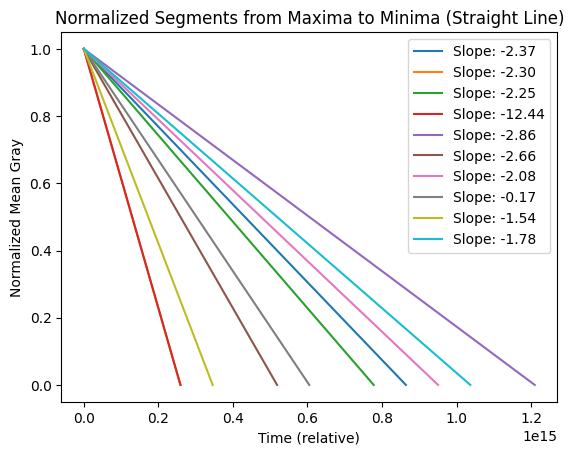

In [528]:
# Plot each line from maxima to minima over each other using index as x-axis
fig, ax = plt.subplots()

# Iterate through the filtered_combined DataFrame
for i in range(1, len(filtered_combined)):
    start = filtered_combined.index[i-1]
    end = filtered_combined.index[i]
    
    # Extract the values at the start and end points
    start_value = filtered_combined.loc[start, 'mean_gray']
    end_value = filtered_combined.loc[end, 'mean_gray']
    
    # Create a straight line segment
    line_segment = pd.Series([start_value, end_value], index=[start, end])
    
    # Normalize the segment
    normalized_segment = (line_segment - line_segment.min()) / (line_segment.max() - line_segment.min())
    
    # Only plot segments that start at 1 for Y axis
    if normalized_segment.iloc[0] == 1:
        # Calculate the slope
        delta_y = end_value - start_value
        delta_x = (end - start).days
        slope = delta_y / delta_x if delta_x != 0 else float('inf')
        
        # Plot the normalized segment using the index as x-axis
        ax.plot(normalized_segment.index - normalized_segment.index[0], normalized_segment.values, label=f'Slope: {slope:.2f}')
        
# Add labels, title, and legend
ax.set_xlabel('Time (relative)')
ax.set_ylabel('Normalized Mean Gray')
ax.set_title('Normalized Segments from Maxima to Minima (Straight Line)')
ax.legend()

plt.show()


## Check out slopes for each day

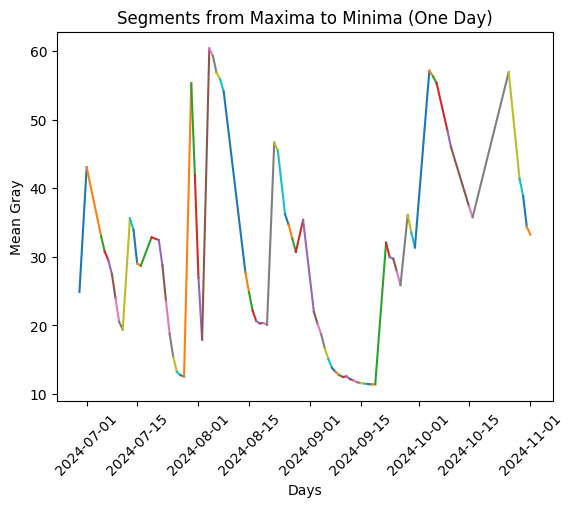

In [529]:
# Plot each day in a different color

# Plot each line from maxima to minima over each other using index as x-axis
fig, ax = plt.subplots()

# Iterate through the filtered_combined DataFrame
for i in range(1, len(df_cleaned)):
    start = df_cleaned.index[i-1]
    end = df_cleaned.index[i]
    
    # Extract the segment between the current maxima and minima
    segment = df_cleaned.loc[start:end, 'mean_gray']
    
    # Calculate the slope
    delta_y = segment.iloc[-1] - segment.iloc[0]
    delta_x = (end - start).days
    slope = delta_y / delta_x if delta_x != 0 else float('inf')
    
    # Plot the segment using the index as x-axis
    ax.plot(segment.index, segment.values, label=f'{start.date()} to {end.date()} (Slope: {slope:.2f})')

# Add labels and title
ax.set_xlabel('Days')
ax.set_ylabel('Mean Gray')
ax.set_title('Segments from Maxima to Minima (One Day)')
plt.xticks(rotation=45)

plt.show()


In [530]:
df_cleaned_sorted = df_cleaned.sort_values(by='slope')
df_cleaned_sorted.head(10)

,mean_gray,mean_gray_diff,mean_gray_diff_normalized,count_pixels_lighter,week_of_year,slope
time,,,,,,
2024-08-01,26.907184,0.570867,0.008147,52974852,31,-14.987794
2024-07-31,41.894978,0.916913,0.013085,56839763,31,-13.379509
2024-08-02,17.949644,0.452316,0.006455,40906002,31,-8.957540
2024-07-23,23.498522,0.841574,0.012010,69510519,30,-5.258250
2024-07-15,29.035055,0.720441,0.010282,86875118,29,-4.845654
2024-07-24,18.790269,1.469854,0.020976,58286622,30,-4.708253
2024-10-31,34.391360,0.770095,0.010990,135642726,44,-4.481085
2024-08-14,27.752415,0.444594,0.006345,65035921,33,-4.476902
2024-09-02,21.955984,1.422478,0.020300,58109770,36,-4.233672


## Check amount of worms detected for each day

In [531]:
# Load the CSV file into a DataFrame
detections = pd.read_csv('./data/csv/image-predictions.csv', usecols=['time', 'class', 'confidence', 'x', 'y', 'width', 'height'])

# Convert the 'time' column to datetime format
detections['time'] = pd.to_datetime(detections['time'])

detections

,time,x,y,width,height,class,confidence
0,2024-08-18 22:58:11.784157,486,428,57,27,worm,0.186
1,2024-08-19 08:49:07.848705,514,430,123,30,worm,0.357
2,2024-08-19 08:49:07.848705,957,252,75,118,worm,0.320
3,2024-08-19 09:01:47.573271,959,249,75,121,worm,0.779
4,2024-08-19 09:01:47.573271,503,429,102,28,worm,0.378
...,...,...,...,...,...,...,...
141629,2024-11-08 13:38:35.302109,82,83,131,160,worm,0.159
141630,2024-11-08 13:41:35.270319,78,83,134,160,worm,0.180
141631,2024-11-08 14:16:35.237698,966,446,115,74,worm,0.209
141632,2024-11-08 14:25:35.302170,93,84,140,165,worm,0.116


In [532]:
from shapely.geometry import box

# Function to check if two bounding boxes overlap
def is_overlap(row1, row2):
    box1 = box(row1['x'], row1['y'], row1['x'] + row1['width'], row1['y'] + row1['height'])
    box2 = box(row2['x'], row2['y'], row2['x'] + row2['width'], row2['y'] + row2['height'])
    return box1.intersects(box2)

# Sort detections by time
detections_sorted = detections.sort_values(by='time')

# Initialize a list to keep track of rows to keep
rows_to_keep = []

# Iterate through the sorted detections
for i, row in detections_sorted.iterrows():
    if i == 0:
        rows_to_keep.append(i)
    else:
        previous_row = detections_sorted.iloc[i - 1]
        if not is_overlap(row, previous_row):
            rows_to_keep.append(i)

# Filter the DataFrame to keep only non-overlapping rows
detections_non_overlapping = detections_sorted.loc[rows_to_keep]

detections_non_overlapping

,time,x,y,width,height,class,confidence
0,2024-08-18 22:58:11.784157,486,428,57,27,worm,0.186
2,2024-08-19 08:49:07.848705,957,252,75,118,worm,0.320
4,2024-08-19 09:01:47.573271,503,429,102,28,worm,0.378
5,2024-08-19 09:02:25.545031,958,252,73,118,worm,0.472
6,2024-08-19 09:02:25.545031,506,430,110,31,worm,0.280
...,...,...,...,...,...,...,...
141593,2024-11-08 11:25:35.237122,141,703,126,122,worm,0.560
141594,2024-11-08 11:25:35.237122,158,270,388,84,worm,0.223
141595,2024-11-08 12:37:35.270221,77,78,134,152,worm,0.106
141631,2024-11-08 14:16:35.237698,966,446,115,74,worm,0.209


In [533]:
detections_worm = detections_non_overlapping[detections_non_overlapping['class'] == 'worm']
detections_worm = detections_worm[detections_worm['confidence'] > 0.7]
detections_worm

,time,x,y,width,height,class,confidence
7,2024-08-19 09:02:58.760496,958,251,73,118,worm,0.747
11,2024-08-19 09:04:51.318607,959,251,73,117,worm,0.767
74,2024-08-19 09:26:51.090341,959,250,75,122,worm,0.787
91,2024-08-19 09:33:51.125340,958,249,73,126,worm,0.763
95,2024-08-19 09:34:51.282658,958,250,75,124,worm,0.728
...,...,...,...,...,...,...,...
138136,2024-11-02 11:28:35.270288,457,729,195,80,worm,0.805
139105,2024-11-03 14:18:35.107216,913,645,112,58,worm,0.805
140547,2024-11-05 13:10:35.336385,750,730,110,69,worm,0.735
140617,2024-11-05 14:29:35.302545,937,510,168,60,worm,0.745


In [534]:
# Group by day
detections_worm_by_day = detections_worm.resample('D', on='time').agg({
    'confidence': 'mean',
    'class': 'count'
}).rename(columns={'class': 'detections_count'})

detections_worm_by_day

,confidence,detections_count
time,,
2024-08-19,0.768405,553
2024-08-20,0.748048,105
2024-08-21,0.737481,129
2024-08-22,0.730000,1
2024-08-23,NaN,0
...,...,...
2024-11-01,NaN,0
2024-11-02,0.805000,1
2024-11-03,0.805000,1


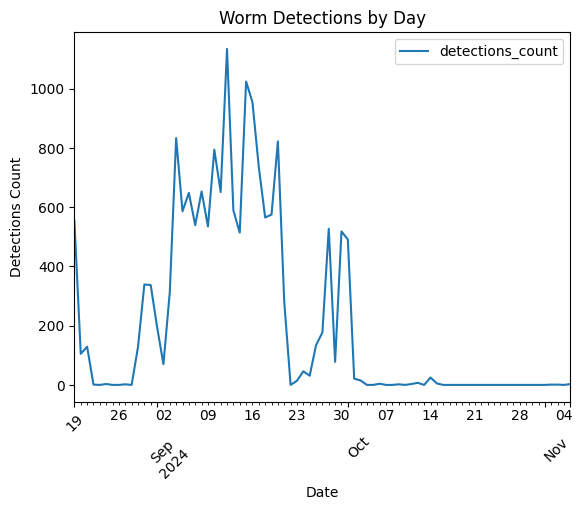

In [535]:
detections_worm_by_day.plot(y='detections_count', kind='line')
plt.xlabel('Date')
plt.ylabel('Detections Count')
plt.title('Worm Detections by Day')
plt.xticks(rotation=45)
plt.show()

In [536]:
# Merge the detections_worm_by_day DataFrame with df_by_day on the 'time' index
merged_df = df_by_day.merge(detections_worm_by_day, left_index=True, right_index=True)
merged_df.sort_values(by='detections_count', ascending=False)
merged_df[merged_df['week_of_year'] == 36]

,mean_gray,mean_gray_diff,mean_gray_diff_normalized,count_pixels_lighter,week_of_year,slope,confidence,detections_count
time,,,,,,,,
2024-09-02,21.955984,1.422478,0.020300,58109770,36,-4.233672,0.777071,70
2024-09-03,20.268495,0.675855,0.009645,52207477,36,-1.687489,0.813981,313
2024-09-04,18.737064,1.086731,0.015509,54064671,36,-1.531432,0.816534,833
2024-09-05,16.707700,1.548242,0.022095,45181624,36,-2.029364,0.802193,586
2024-09-06,15.132532,0.694997,0.009918,38819413,36,-1.575168,0.801812,648
2024-09-07,13.822983,1.478423,0.021099,35526926,36,-1.309549,0.800193,539
2024-09-08,13.237717,4.601519,0.065669,34567111,36,-0.585267,0.787519,653


<Axes: >

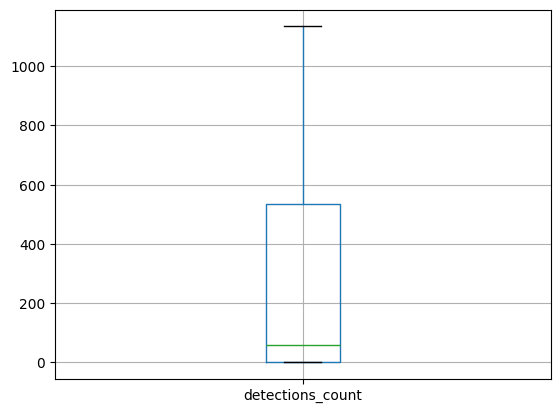

In [537]:
merged_df.boxplot(column='detections_count')

In [538]:
filtered_merged_df = merged_df[merged_df['detections_count'] != 0]
filtered_merged_df = filtered_merged_df[filtered_merged_df['slope'] < 1]
filtered_merged_df.sort_values(by='slope', inplace=True)
filtered_merged_df

,mean_gray,mean_gray_diff,mean_gray_diff_normalized,count_pixels_lighter,week_of_year,slope,confidence,detections_count
time,,,,,,,,
2024-08-24,40.197773,34.462273,0.491816,77534357,34,-5.263991,0.710333,3
2024-09-01,26.189656,7.168187,0.102298,68137866,35,-4.687620,0.788786,196
2024-08-31,30.877277,7.542994,0.107647,72772158,35,-4.506346,0.800187,337
2024-09-02,21.955984,1.422478,0.020300,58109770,36,-4.233672,0.777071,70
2024-09-29,33.530374,0.625341,0.008924,93257365,39,-2.571609,0.748090,78
2024-10-11,43.454847,63.676671,0.908739,97176667,41,-2.529779,0.794000,3
2024-10-09,48.418592,0.398383,0.005685,84136547,41,-2.448790,0.777000,2
2024-10-15,37.338252,0.724524,0.010340,110170003,42,-2.192428,0.839000,5
2024-09-30,31.360065,0.555177,0.007923,96117901,40,-2.170310,0.748591,518


In [539]:
# Calculate the correlation between 'detections_count' and 'slope'
correlation = filtered_merged_df['detections_count'].corr(filtered_merged_df['slope'])

print(f"Correlation between detections_count and slope: {correlation}")

Correlation between detections_count and slope: 0.5534741653369517


In [540]:
filtered_merged_df

,mean_gray,mean_gray_diff,mean_gray_diff_normalized,count_pixels_lighter,week_of_year,slope,confidence,detections_count
time,,,,,,,,
2024-08-24,40.197773,34.462273,0.491816,77534357,34,-5.263991,0.710333,3
2024-09-01,26.189656,7.168187,0.102298,68137866,35,-4.687620,0.788786,196
2024-08-31,30.877277,7.542994,0.107647,72772158,35,-4.506346,0.800187,337
2024-09-02,21.955984,1.422478,0.020300,58109770,36,-4.233672,0.777071,70
2024-09-29,33.530374,0.625341,0.008924,93257365,39,-2.571609,0.748090,78
2024-10-11,43.454847,63.676671,0.908739,97176667,41,-2.529779,0.794000,3
2024-10-09,48.418592,0.398383,0.005685,84136547,41,-2.448790,0.777000,2
2024-10-15,37.338252,0.724524,0.010340,110170003,42,-2.192428,0.839000,5
2024-09-30,31.360065,0.555177,0.007923,96117901,40,-2.170310,0.748591,518


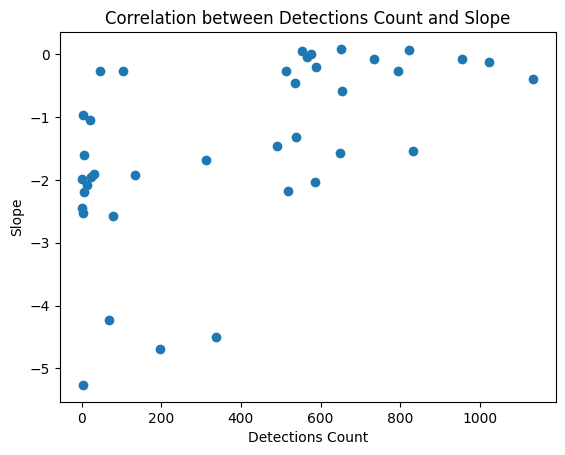

In [541]:
# Plot the correlation between 'detections_count' and 'slope'
plt.scatter(filtered_merged_df['detections_count'], filtered_merged_df['slope'])
plt.xlabel('Detections Count')
plt.ylabel('Slope')
plt.title('Correlation between Detections Count and Slope')
plt.show()

## Check correlation between slope and activity

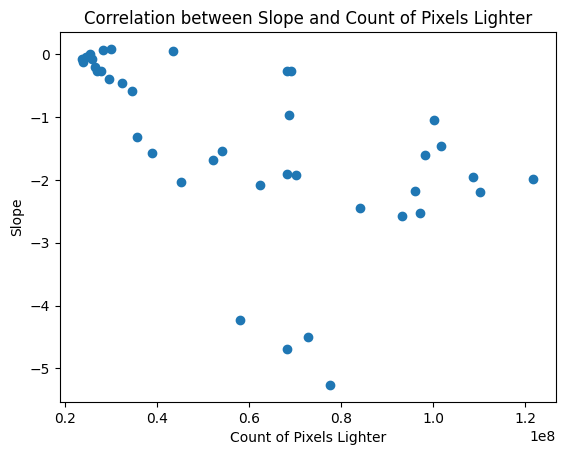

In [544]:
# Plot the correlation between 'slope' and 'count_pixels_lighter'
plt.scatter(filtered_merged_df['count_pixels_lighter'], filtered_merged_df['slope'])
plt.xlabel('Count of Pixels Lighter')
plt.ylabel('Slope')
plt.title('Correlation between Slope and Count of Pixels Lighter')
plt.show()